In [ ]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline 
# %matplotlib qt 

import matplotlib.pyplot as plt
import numpy
import yaml
import os
from scipy.ndimage import zoom, affine_transform
import imageio
import torch.nn
from typing import Union, Tuple, List, Sequence, Optional, Any,OrderedDict
import collections
import numpy
import torch.nn.functional
from scipy.ndimage import affine_transform

In [ ]:
os.chdir("/repos/lnet")
from lnet.utils.affine import inv_scipy_form2torch_form_2d, inv_scipy_form2torch_form_3d, scipy_form2torch_form_2d
from lnet.setup import Stage
from lnet.datasets.base import TensorInfo, get_dataset_from_info, ZipDataset, N5CachedDataset
from lnet.transformations import AffineTransformation, Normalize01

In [ ]:
lrds = get_dataset_from_info(TensorInfo(
    "lr", "lnet", "ref_data/AffineTransforms/SwipeThrough_-450_-210_nimages_241/Gcamp_dataset.h5/t[0-9]+/s00/0/cells", transforms=[], meta={}, insert_singleton_axes_at=[0, 0]
))
lrds = N5CachedDataset(lrds)
lsds = get_dataset_from_info(TensorInfo(
    "ls", "lnet", "ref_data/AffineTransforms/SwipeThrough_-450_-210_nimages_241/Gcamp_dataset.h5/t[0-9]+/s01/0/cells", transforms=[], meta={}, insert_singleton_axes_at=[0, 0]
))
lsds = N5CachedDataset(lsds)
ds = ZipDataset({"lr": lrds, "ls": lsds}, transformation=Normalize01(apply_to= ["ls", "lr"], min_percentile=0, max_percentile=100))
only_lr_ds = ZipDataset({"lr": lrds}, transformation=Normalize01(apply_to= ["lr"], min_percentile=0, max_percentile=100))

In [ ]:
sample = ds[0]
print('lr', sample["lr"].shape)
img_lr = sample["lr"][0, 0].max(0)
print('ls', sample["ls"].shape)
img_ls = sample["ls"][0, 0].max(0)

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(img_lr)

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(img_ls)

In [ ]:
sample = ds[0]

In [ ]:
def scipy_form2torch_theta(scipy_form, ipt_shape, out_shape) -> torch.Tensor:
    assert len(scipy_form.shape) == 2
    assert not scipy_form[-1, :-1].any()    
    assert scipy_form[-1, -1] == 1
    norm_i = numpy.diag([2 / s for s in ipt_shape] + [1])
    norm_i[:-1, -1] = -1
    norm_o = numpy.diag(list(out_shape) + [2])
    norm_o[:-1, -1] = out_shape
    norm_o = norm_o / 2
    scipy_normed = norm_i.dot(scipy_form).dot(norm_o)
    assert not scipy_normed[-1, :-1].any()
    
    # transpose axis to match scipy implementation
    theta4x4 = numpy.zeros_like(scipy_normed)
    theta4x4[:-1, :-1] = scipy_normed[-2::-1, -2::-1]
    theta4x4[:-1, -1] = scipy_normed[-2::-1, -1]
    theta4x4[-1, -1] = scipy_normed[-1, -1]

    # return with batch dimension as 1x3x4
    return torch.from_numpy(theta4x4[None, :-1])

def bdv_trafo_to_affine_matrix(trafo):
    """from https://github.com/constantinpape/elf/blob/7b7cd21e632a07876a1302dad92f8d7c1929b37a/elf/transformation/affine.py#L162
    Translate bdv transformation (XYZ) to affine matrix (ZYX)

    """
    if len(trafo) == 12:
        assert trafo[10] != 0.0
        assert trafo[5] != 0.0
        assert trafo[0] != 0.0
        sub_matrix = numpy.zeros((3, 3))
        sub_matrix[0, 0] = trafo[10]
        sub_matrix[0, 1] = trafo[9]
        sub_matrix[0, 2] = trafo[8]

        sub_matrix[1, 0] = trafo[6]
        sub_matrix[1, 1] = trafo[5]
        sub_matrix[1, 2] = trafo[4]

        sub_matrix[2, 0] = trafo[2]
        sub_matrix[2, 1] = trafo[1]
        sub_matrix[2, 2] = trafo[0]

        shift = [trafo[11], trafo[7], trafo[3]]

        matrix = numpy.zeros((4, 4))
        matrix[:3, :3] = sub_matrix
        matrix[:3, 3] = shift
        matrix[3, 3] = 1

        return matrix
    elif len(trafo) == 6:
        raise NotImplementedError("just a guess...")
        assert trafo[4] != 0.0
        assert trafo[0] != 0.0
        matrix = numpy.eye(3)
        matrix[0, 0] = trafo[4]
        matrix[0, 1] = trafo[3]
        matrix[1, 0] = trafo[1]
        matrix[1, 1] = trafo[0]
        matrix[0, 2] = trafo[5]
        matrix[1, 2] = trafo[2]
        return matrix
    else:
        raise NotImplementedError(trafo)

In [ ]:
class AffineTransformation(torch.nn.Module):
    mode_from_order = {0: "nearest", 2: "bilinear"}

    def __init__(
        self,
        *,
        apply_to: str,
        target_to_compare_to: str,
        order: int,
        input_shape: Sequence[int],
        bdv_affine_transformations: List[List[float]],  # Fiij's big data viewer affine transformations: each affine transformation as a list of 12 floats.
        # affine_matrices: List[List[float]],
        output_shape: Sequence[int],
        inverted: bool = False,
        crop_out: Optional[Tuple[Tuple[int, int], ...]] = None,
        crop_in: Optional[Tuple[Tuple[int, int], ...]] = None,
    ):
        if len(input_shape) not in (2, 3):
            raise NotImplementedError

        if len(output_shape) not in (2, 3):
            raise NotImplementedError

        super().__init__()
        self.apply_to = apply_to
        self.target_to_compare_to = target_to_compare_to
        self.input_shape = input_shape
        self.output_shape = output_shape

        self.mode = self.mode_from_order[order]

        trf_matrices = [bdv_trafo_to_affine_matrix(m) for m in bdv_affine_transformations]
        trf_matrix = trf_matrices[0]
        for m in trf_matrices[1:]:
            trf_matrix = trf_matrix.dot(m)

        self.affine_grids = {}

        self.forward = self.inverted if inverted else self._forward
        if crop_out is None:
            self.order = 0
            ones_out = self._impl(
                numpy.ones((1, 1) + self.input_shape, dtype=numpy.uint8),
                matrix=numpy.linalg.inv(trf_matrix),
                trf_in_shape=self.input_shape,
                trf_out_shape=self.output_shape,
            )[0, 0]
            dims = []
            if len(ones_out.shape) == 3:
                dims.append(ones_out.max(1).max(1))
                ones_out_2d = ones_out.max(0)
                dims.append(ones_out_2d.max(1))
                dims.append(ones_out_2d.max(0))
            else:
                raise NotImplementedError

            crop_out = [(numpy.argmax(dim), -numpy.argmax(dim[::-1])) for dim in dims]
            print("determined crop_out:", crop_out)
        elif len(crop_out) == len(output_shape) + 1:
            assert crop_out[0][0] == 0 and crop_out[0][1] == 0, crop_out
            crop_out = crop_out[1:]

        if crop_in is None:
            crop_in = tuple([(0, 0) for _ in range(len(input_shape))])
        elif len(crop_in) == len(input_shape) + 1:
            assert crop_in[0][0] == 0 and crop_in[0][1] == 0, crop_in
            crop_in = crop_in[1:]

        self.z_offset = crop_out[0][0]
        self.cropped_output_shape = tuple(
            [c[1] - c[0] if c[1] > 0 else outs - c[0] + c[1] for outs, c in zip(self.output_shape, crop_out)]
        )
        self.cropped_input_shape = tuple(
            [c[1] - c[0] if c[1] > 0 else ins - c[0] + c[1] for ins, c in zip(self.input_shape, crop_in)]
        )

        self.order = order
        crop_shift_in = numpy.eye(len(input_shape) + 1, dtype=trf_matrix.dtype)
        crop_shift_in[:-1, -1] = [-c[0] for c in crop_in]
        crop_shift_out = numpy.eye(len(output_shape) + 1, dtype=trf_matrix.dtype)
        crop_shift_out[:-1, -1] = [c[0] for c in crop_out]
        self.trf_matrix = crop_shift_in.dot(trf_matrix.dot(crop_shift_out))

    #         self.inv_trf_matrix = numpy.linalg.inv(self.trf_matrix)

    @staticmethod
    def get_affine_grid(scipy_form, ipt_shape, out_shape):
        assert len(scipy_form.shape) == 2, scipy_form.shape
        assert len(ipt_shape) in (2, 3)
        assert len(ipt_shape) == len(out_shape), (ipt_shape, out_shape)
        theta = scipy_form2torch_theta(scipy_form, ipt_shape, out_shape)
        affine_grid_size = (1, 1) + tuple(out_shape)
        return torch.nn.functional.affine_grid(theta=theta, size=affine_grid_size, align_corners=False)

    def _impl(
        self,
        *,
        ipt: Union[torch.Tensor, numpy.ndarray],
        matrix: numpy.ndarray,
        trf_in_shape: Tuple[int, ...],
        trf_out_shape: Tuple[int, ...],
        output_sampling_shape: Optional[Tuple[int, ...]] = None,
        z_slices: Optional[Sequence[int]] = None,
    ) -> Union[numpy.ndarray, torch.Tensor]:
        print("ipt shape", ipt.shape)
        print("trf in shape", trf_in_shape)
        print("trf out shape", trf_out_shape)
        print("out sampling shape", output_sampling_shape)
        if output_sampling_shape is None:
            output_sampling_shape = trf_out_shape
        elif z_slices is not None and any([zs is not None for zs in z_slices]):
            raise ValueError("exclusive args: z_slices, output_sampling_shape")

        if trf_in_shape != ipt.shape[2:]:
            in_scaling = [ipts / trf_in for ipts, trf_in in zip(ipt.shape[2:], trf_in_shape)] + [1.0]
            print("ipt.shape -> trf_in_shape", in_scaling)
            matrix = numpy.diag(in_scaling).dot(matrix)

        if trf_out_shape != output_sampling_shape:
            out_scaling = [trf_out / outs for trf_out, outs in zip(trf_out_shape, output_sampling_shape)] + [1.0]
            print("trf_out_shape -> output_sampling", out_scaling)
            matrix = matrix.dot(numpy.diag(out_scaling))

        if isinstance(ipt, numpy.ndarray):
            assert len(ipt.shape) in [4, 5], ipt.shape
            return numpy.stack(
                [
                    numpy.stack(
                        [
                            affine_transform(ipt_woc, matrix, output_shape=output_sampling_shape, order=self.order)
                            for ipt_woc in ipt_wc
                        ]
                    )
                    for ipt_wc in ipt
                ]
            )
        elif isinstance(ipt, torch.Tensor):
            on_cuda = False
            ipt_was_cuda = ipt.is_cuda
            if on_cuda != ipt.is_cuda:
                if on_cuda:
                    ipt = ipt.to(torch.device("cuda:0"))
                else:
                    ipt = ipt.to(torch.device("cpu"))

            affine_grid_key = (matrix.tostring(), ipt.shape[2:], output_sampling_shape)
            affine_grid = self.affine_grids.get(affine_grid_key, None)
            if affine_grid is None:
                affine_grid = self.get_affine_grid(matrix, ipt.shape[2:], output_sampling_shape)
                affine_grid.to(ipt)
                self.affine_grids[affine_grid_key] = affine_grid

            affine_grid = affine_grid.to(ipt)

            if z_slices is None or all([zs is None for zs in z_slices]):
                affine_grid = affine_grid.expand(ipt.shape[0], *([-1] * (len(ipt.shape) - 1)))
            else:
                assert all([zs is not None for zs in z_slices]), z_slices
                assert len(z_slices) == ipt.shape[0], (z_slices, ipt.shape)
                assert all(self.z_offset <= z_slice for z_slice in z_slices), (self.z_offset, z_slices)
                affine_grid = torch.cat(
                    [
                        self.affine_torch_grid[:, z_slice - self.z_offset : z_slice + 1 - self.z_offset]
                        for z_slice in z_slices
                    ]
                )

            ret = torch.nn.functional.grid_sample(
                ipt, affine_grid, align_corners=False, mode=self.mode, padding_mode="zeros"  # "border"
            )
            if not (z_slices is None or all([zs is None for zs in z_slices])):
                assert ret.shape[2] == 1, ret.shape
                ret = ret[:, :, 0]

            if on_cuda == ipt_was_cuda:
                return ret
            elif ipt_was_cuda:
                return ret.to(device=torch.device("cuda:0"))
            else:
                return ret.to(device=torch.device("cpu"))
        else:
            raise TypeError(type(ipt))

    def inverted(self, ipt: Union[torch.Tensor, numpy.ndarray], **kwargs) -> OrderedDict[str, Any]:
        raise NotImplementedError
        ipt = tensors[self.apply_to]
        tgt = tensors[self.target_to_compare_to]

        return self._impl(
            ipt, matrix=self.trf_matrix, trf_in_shape=self.output_shape, trf_out_shape=self.input_shape, **kwargs
        )

    def _forward(self, img_shape, tensors: OrderedDict[str, Any]) -> OrderedDict[str, Any]:
        #         for meta in tensors["meta"]:
        #             tmeta = meta[self.target_to_compare_to]
        #             assert tmeta["shape_before_resize"][1:] == self.cropped_output_shape, (
        #                 tmeta["shape_before_resize"],
        #                 self.cropped_output_shape,
        #             )

        #         output_sampling_shape = (
        #             None  # sample output as trf output and select z_slice (for 2d target) ...
        #             if len(tensors[self.target_to_compare_to].shape) == 4
        #             else tuple(tensors[self.target_to_compare_to].shape[2:])  # ...or resample output to compare to volumetric target
        #         )
        tensors[self.apply_to] = self._impl(
            ipt=tensors[self.apply_to],
            matrix=self.trf_matrix,
            trf_in_shape=self.cropped_input_shape,
            trf_out_shape=self.cropped_output_shape,
            #             output_sampling_shape=(84, 133, 162),
            #             output_sampling_shape=(100, 200),
            output_sampling_shape=(100, 200, 300),
            z_slices=[m.get("z_slice", None) for m in tensors["meta"]],
        )
        return tensors

trf = AffineTransformation(apply_to="lr", target_to_compare_to="ls", order=0, input_shape=(838, 1330, 1615), output_shape=(241, 1501, 1801), bdv_affine_transformations=[[0.98048,0.004709,0.098297,-111.7542,7.6415e-05,0.97546,0.0030523,-20.1143,0.014629,8.2964e-06,-3.9928,846.8515]], crop_in=[(0, 0), (0, 0), (0, 0)], crop_out=[(3, -22), (20, -117), (87, -41)])
# trf = AffineTransformation(apply_to="lr", target_to_compare_to="ls", order=0, input_shape=(838, 1330, 1615), output_shape=(241, 1501, 1801), bdv_affine_transformations=[[0.98048,0.004709,0.098297,-111.7542,7.6415e-05,0.97546,0.0030523,-20.1143,0.014629,8.2964e-06,-3.9928,846.8515]], crop_in=[(0, 0), (0, 0), (0, 0)], crop_out=[(0, 0), (0, 0), (0, 0)])
# trf = AffineTransformation(apply_to="lr", target_to_compare_to="ls", order=0, input_shape=(838, 1330, 1615), output_shape=(241, 1501, 1801), bdv_affine_transformations=[[0.98048,0.004709,0.098297,-111.7542,7.6415e-05,0.97546,0.0030523,-20.1143,0.014629,8.2964e-06,-3.9928,846.8515]], crop_in=[(0, 0), (0, 0), (0, 0)], crop_out=[(0, 0), (0, 0), (0, 0)])
# trf = AffineTransformation(apply_to="lr", target_to_compare_to="ls", order=0, input_shape=(838, 1330, 1615), output_shape=(241, 1501, 1801), bdv_affine_transformations=[[0.98048,0.004709,0.098297,-111.7542,7.6415e-05,0.97546,0.0030523,-20.1143,0.014629,8.2964e-06,-3.9928,846.8515]], crop_in=[(0, 0), (0, 0), (0, 0)], crop_out=[(0, 0), (0, 0), (0, 0)])
# trf = AffineTransformation(apply_to="lr", target_to_compare_to="ls", order=0, input_shape=(1330, 1615), output_shape=(1501, 1801), bdv_affine_transformations=[[0.98048,0.004709,-111.7542,7.6415e-05,0.97546,-20.1143]], crop_in=[(0, 0), (0, 0)], crop_out=[(0, 0), (0, 0)])
# trf = AffineTransformation(apply_to="lr", target_to_compare_to="ls", order=0, input_shape=(100, 200), output_shape=(100, 200), bdv_affine_transformations=[[1.0, 0.0, 0.0 , 0.0, 1.0, 10.0]], crop_in=[(0, 0), (0, 0)], crop_out=[(0, 0), (0, 0)])
# trf = AffineTransformation(apply_to="lr", target_to_compare_to="ls", order=0, input_shape=(100, 200, 300), output_shape=(100, 200, 300), bdv_affine_transformations=[[.5, 0.0, 0.0, 0.0 , 0.0, .5, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]], crop_in=[(0, 0), (50, 0), (0, 0)], crop_out=[(0, 0), (0, 0), (0, 0)])


In [ ]:
# lr_ipt = only_lr_ds[0]["lr"][:, :, 5:-5, 10:-10, 10:-10]
ipt_size = (1, 1, 100, 200, 300)
lr_ipt = numpy.ones(ipt_size, dtype="float64")
img_shape = None
out_torch = trf(img_shape, {"lr": torch.from_numpy(lr_ipt).cuda(), "meta": [{}]})["lr"][0, 0].cpu().numpy()

lr_ipt = numpy.ones(ipt_size, dtype="float64")
out = trf(img_shape, {"lr": lr_ipt, "meta": [{}]})["lr"][0, 0]

In [ ]:
print(out.shape, out_torch.shape)
fig, ax = plt.subplots(ncols=3, figsize=(30, 10))

for i in range(3):
    out_img = out.max(i)
    out_torch_img = out_torch.max(i)
    img = numpy.zeros_like(out_img)
    img[::2, ::2] = out_img[::2, ::2]
    img[1::2, 1::2] = out_img[1::2, 1::2]
    img[::2, 1::2] = -out_torch_img[::2, 1::2]
    img[1::2, ::2] = -out_torch_img[1::2, ::2]
    ax[i].imshow(img)

(100, 200, 300) (100, 200, 300)


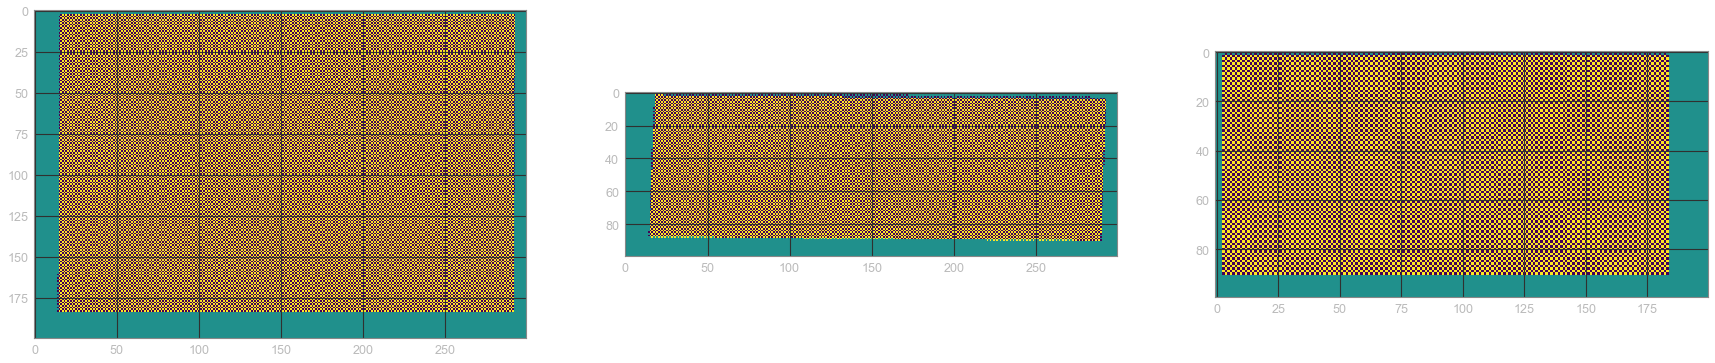

In [61]:
print(out.shape, out_torch.shape)
fig, ax = plt.subplots(ncols=3, figsize=(30, 10))

for i in range(3):
    out_img = out.max(i)
    out_torch_img = out_torch.max(i)
    img = numpy.zeros_like(out_img)
    img[::2, ::2] = out_img[::2, ::2]
    img[1::2, 1::2] = out_img[1::2, 1::2]
    img[::2, 1::2] = -out_torch_img[::2, 1::2]
    img[1::2, ::2] = -out_torch_img[1::2, ::2]
    ax[i].imshow(img)

In [ ]:
# lr_ipt = only_lr_ds[0]["lr"][:, :, 5:-5, 10:-10, 10:-10]


In [ ]:
out.shape

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(out[0])

In [ ]:
# plt.figure(figsize=(10, 10))
# plt.imshow(out_torch.max(1))

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(out_torch.max(2))

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(out.max(1))

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(out.max(2))

In [ ]:

out_ones = trf({"lr": numpy.ones((1, 1, 49, 1330, 1615))}, select_output_shape=(241, 1501, 1801))

In [ ]:
out_ones[0, 0].max(0).max(1).shape

In [ ]:
1501- 117

In [ ]:
numpy.argmax(out_ones[0, 0].max(0).max(1)[::-1])

In [ ]:
out_ones[0, 0].max(0).max(1)[1383:1384+10]

In [ ]:
out = trf(sample, select_output_shape=(24, 150, 180))["lr"]

In [ ]:
out.min(), out.max(), out.dtype

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(out[0, 0].max(0))

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(out[0, 0].max(1))

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(sample["ls"][0, 0].max(0))

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(sample["ls"][0, 0].max(1))

In [ ]:
plt.figure(figsize=(15, 15))
# nout = out / out.max()
# inn = sample["ls"] / sample["ls"].max()
# plt.imshow(numpy.stack([nout.max(0)], axis=2))
plt.imshow(nout[0, 0].max(0) - inn[0, 0].max(0))
# plt.imshow((nout - inn).max(0))

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow((nout - inn)[0, 0].max(0))

In [ ]:
print(out.max(), out.min(), out.dtype)
out16 = (out.astype("float32") + 32768).astype("uint16")
print(out16.max(), out16.min(), out16.dtype)

In [ ]:
imageio.volwrite("ref_data/AffineTransforms/SwipeThrough_-450_-210_nimages_241/out.tif", out16[0, 0])

In [ ]:
class BDVTransform(torch.nn.Module):
    mode_from_order = {0: "nearest", 2: "bilinear"}

    # to be set by subclass
    ls_shape: Union[Tuple[int, int], Tuple[int, int, int]]
    lf2ls_crop: Union[Tuple[Tuple[int, int], Tuple[int, int]], Tuple[Tuple[int, int], Tuple[int, int], Tuple[int, int]]]
    lf_shape: Union[Tuple[int, int], Tuple[int, int, int]]
    affine_transforms: Tuple[Tuple[float]]

    def __init__(
        self,
        output_shape: Optional[Union[Tuple[int, int], Tuple[int, int, int]]] = None,
        order: int = 0,
        additional_transforms_left: Sequence[numpy.ndarray] = tuple(),
        additional_transforms_right: Sequence[numpy.ndarray] = tuple(),
        forward: str = "lf2ls",
        trf_out_zoom: Tuple[float, float, float] = (1.0, 1.0, 1.0),
        lf_shape: Optional[Tuple[int, int, int]] = None,
    ):
        if output_shape is not None and len(output_shape) == 2:
            raise NotImplementedError

        # check if correctly inherited
        assert hasattr(self, "affine_transforms") and isinstance(self.affine_transforms, tuple)
        assert hasattr(self, "ls_shape") and isinstance(self.ls_shape, tuple)
        assert hasattr(self, "lf2ls_crop") and isinstance(self.lf2ls_crop, tuple)
        assert hasattr(self, "lf_shape") and isinstance(self.lf_shape, tuple)

        if lf_shape is not None:
            self.lf_shape = lf_shape

        assert forward in ["lf2ls", "ls2lf"]
        self.forward = getattr(self, forward)
        super().__init__()
        self.trf_out_zoom = trf_out_zoom
        assert output_shape is None or isinstance(output_shape, tuple)
        self.mode = self.mode_from_order.get(order, None)

        self.trf_matrix = self.concat_affine_matrices(
            list(additional_transforms_left)
            + [self.bdv_trafo_to_affine_matrix(at) for at in self.affine_transforms]
            + list(additional_transforms_right)
        )
        self.inv_trf_matrix = numpy.linalg.inv(self.trf_matrix)
        lf2ls_crop_shift = numpy.eye(len(self.ls_shape) + 1, dtype=self.trf_matrix.dtype)
        lf2ls_crop_shift[:-1, -1] = [c[0] for c in self.lf2ls_crop]
        matrix_with_lf2ls_crop = self.trf_matrix.dot(lf2ls_crop_shift)
        self.lf2ls_matrix = numpy.linalg.inv(matrix_with_lf2ls_crop)
        self.output_shape = output_shape
        self.order = order
        self.affine_grid_size = None
        self.z_offset: int = self.lf2ls_crop[0][0]

    @staticmethod
    def bdv_trafo_to_affine_matrix(trafo):
        """ Translate bdv transformation (XYZ) to affine matrix (ZYX)
        """
        assert len(trafo) == 12

        assert trafo[10] != 0.0
        assert trafo[5] != 0.0
        assert trafo[0] != 0.0
        sub_matrix = numpy.zeros((3, 3))
        sub_matrix[0, 0] = trafo[10]
        sub_matrix[0, 1] = trafo[9]
        sub_matrix[0, 2] = trafo[8]

        sub_matrix[1, 0] = trafo[6]
        sub_matrix[1, 1] = trafo[5]
        sub_matrix[1, 2] = trafo[4]

        sub_matrix[2, 0] = trafo[2]
        sub_matrix[2, 1] = trafo[1]
        sub_matrix[2, 2] = trafo[0]

        shift = [trafo[11], trafo[7], trafo[3]]

        matrix = numpy.zeros((4, 4))
        matrix[:3, :3] = sub_matrix
        matrix[:3, 3] = shift
        matrix[3, 3] = 1

        return matrix

    @staticmethod
    def concat_affine_matrices(matrices: List[numpy.ndarray]):
        assert all(m.shape == (4, 4) for m in matrices), [m.shape for m in matrices]
        ret = matrices[0]
        for m in matrices[1:]:
            ret = ret.dot(m)

        return ret

    def _ls2lf(
        self,
        ipt: Union[torch.Tensor, numpy.ndarray],
        matrix: numpy.ndarray,
        trf_in_shape: Optional[Union[Tuple[int, int], Tuple[int, int, int]]] = None,
        trf_out_shape: Optional[Union[Tuple[int, int], Tuple[int, int, int]]] = None,
        output_shape: Optional[Union[Tuple[int, int], Tuple[int, int, int]]] = None,
        order: Optional[int] = None,
        z_slices: Optional[Sequence[int]] = None,
    ) -> Union[numpy.ndarray, torch.Tensor]:
        output_shape = output_shape or self.output_shape
        order = order or self.order
        mode = self.mode_from_order[order]
        if isinstance(ipt, numpy.ndarray):
            assert len(ipt.shape) == 3, ipt.shape
            if trf_in_shape != ipt.shape:
                in_scaling = [trf_in / ipts for ipts, trf_in in zip(ipt.shape, trf_in_shape)] + [1.0]
                matrix = matrix.dot(numpy.diag(in_scaling))

            if trf_out_shape != output_shape:
                out_scaling = [outs / trf_out for trf_out, outs in zip(trf_out_shape, output_shape)] + [1.0]
                matrix = numpy.diag(out_scaling).dot(matrix)

            return affine_transform(ipt, numpy.linalg.inv(matrix), output_shape=output_shape, order=order)
        elif isinstance(ipt, torch.Tensor):
            if len(ipt.shape) == 4:
                torch_form = inv_scipy_form2torch_form_2d(
                    matrix,
                    ipt_shape=ipt.shape[2:],
                    trf_in_shape=trf_in_shape,
                    trf_out_shape=trf_out_shape,
                    out_shape=output_shape,
                )
            elif len(ipt.shape) == 5:
                torch_form = inv_scipy_form2torch_form_3d(
                    matrix,
                    ipt_shape=ipt.shape[2:],
                    trf_in_shape=trf_in_shape,
                    trf_out_shape=trf_out_shape,
                    out_shape=output_shape,
                )
            else:
                raise ValueError(ipt.shape)

            # affine_grid_size = tuple(ipt.shape[:2]) + output_shape
            affine_grid_size = (1, 1) + output_shape
            if self.affine_grid_size != affine_grid_size:
                self.affine_torch_grid = torch.nn.functional.affine_grid(
                    theta=torch_form, size=affine_grid_size, align_corners=False
                )

            on_cuda = ipt.is_cuda
            if on_cuda != ipt.is_cuda:
                if on_cuda:
                    ipt = ipt.to(torch.device("cuda:0"))
                else:
                    ipt = ipt.to(torch.device("cpu"))

            self.affine_torch_grid = self.affine_torch_grid.to(ipt)

            if z_slices is None:
                affine_grid = self.affine_torch_grid.repeat(ipt.shape[0], 1, 1, 1, 1)
            else:
                assert len(z_slices) == ipt.shape[0], (z_slices, ipt.shape)
                assert all(self.z_offset <= z_slice for z_slice in z_slices), (self.z_offset, z_slices)
                affine_grid = torch.cat(
                    [
                        self.affine_torch_grid[:, z_slice - self.z_offset : z_slice + 1 - self.z_offset]
                        for z_slice in z_slices
                    ]
                )

            ret = torch.nn.functional.grid_sample(
                ipt, affine_grid, align_corners=False, mode=mode, padding_mode="border"
            )
            if z_slices is not None:
                assert ret.shape[2] == 1
                ret = ret[:, :, 0]

            if on_cuda == ipt.is_cuda:
                return ret
            elif ipt.is_cuda:
                return ret.to(device=torch.device("cuda:0"))
            else:
                return ret.to(device=torch.device("cpu"))
        else:
            raise TypeError(type(ipt))

    def ls2lf(self, ipt: Union[torch.Tensor, numpy.ndarray], **kwargs) -> Union[numpy.ndarray, torch.Tensor]:
        raise NotImplementedError("trf_out_zoom")
        return self._ls2lf(
            ipt, matrix=self.trf_matrix, trf_in_shape=self.ls_shape, trf_out_shape=self.lf_shape, **kwargs
        )

    def lf2ls(self, ipt: Union[torch.Tensor, numpy.ndarray], **kwargs) -> Union[numpy.ndarray, torch.Tensor]:
        cropped_ls_shape: Union[Tuple[int, int], Tuple[int, int, int]] = tuple(
            (lss - ls_crop[0] - ls_crop[1]) * zoom
            for lss, ls_crop, zoom in zip(self.ls_shape, self.lf2ls_crop, self.trf_out_zoom)
        )
        return self._ls2lf(
            ipt, matrix=self.lf2ls_matrix, trf_in_shape=self.lf_shape, trf_out_shape=cropped_ls_shape, **kwargs
        )


class TestTransform(BDVTransform):
    affine_transforms = ((0.98048,0.004709,0.098297,-111.7542,7.6415e-05,0.97546,0.0030523,-20.1143,0.014629,8.2964e-06,-3.9928,846.8515),)
#     lf2ls_crop = ((3, 22), (20, 117), (87, 41))
    lf2ls_crop = ((0, 0), (0, 0), (0, 0))
    ls_shape = (241, 1501, 1801)
    lf_shape = (838, 1330, 1615)
    
test_trf = TestTransform(order=2)

In [ ]:
test_sample = ds[0]

In [ ]:
ipt = test_sample["lr"]

In [ ]:
test_out = test_trf(ipt[0, 0], output_shape=(49, 130, 180))
plt.figure(figsize=(10, 10))
plt.imshow(test_out.max(1))

In [ ]:
torch_ipt = torch.from_numpy(ipt)

In [ ]:
torch_test_out = test_trf(torch_ipt, output_shape=(49, 1300, 1800))

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(torch_test_out[0, 0].cpu().numpy().max(1))

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(torch_test_out[0, 0].cpu().numpy().max(0))

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(test_out.max(1))

In [ ]:
class BDVTransform(torch.nn.Module):
    mode_from_order = {0: "nearest", 2: "bilinear"}

    # to be set by subclass
    ls_shape: Union[Tuple[int, int], Tuple[int, int, int]]
    lf2ls_crop: Union[Tuple[Tuple[int, int], Tuple[int, int]], Tuple[Tuple[int, int], Tuple[int, int], Tuple[int, int]]]
    lf_shape: Union[Tuple[int, int], Tuple[int, int, int]]
    affine_transforms: Tuple[Tuple[float]]

    def __init__(
        self,
        *,
        forward: str,
        order: int,
        output_shape: Optional[Union[Tuple[int, int], Tuple[int, int, int]]] = None,
        additional_transforms_left: Sequence[numpy.ndarray] = tuple(),
        additional_transforms_right: Sequence[numpy.ndarray] = tuple(),
        trf_out_zoom: Tuple[float, float, float] = (1.0, 1.0, 1.0),
        lf_shape: Optional[Tuple[int, int, int]] = None,
    ):
        # check if correctly inherited
#         assert hasattr(self, "affine_transforms") and isinstance(self.affine_transforms, tuple), self.affine_transforms
        assert hasattr(self, "ls_shape") and isinstance(self.ls_shape, tuple), self.ls_shape
        assert hasattr(self, "lf2ls_crop") and isinstance(self.lf2ls_crop, tuple), self.lf2ls_crop
        assert hasattr(self, "lf_shape") and isinstance(self.lf_shape, tuple), self.lf_shape

        if forward == "lf2ls":
            self.forward = self.lf2ls
        elif forward == "ls2lf":
            self.forward = self.ls2lf
        else:
            raise NotImplementedError(forward)

        super().__init__()
        assert output_shape is None or isinstance(output_shape, tuple)
        if output_shape is not None and len(output_shape) == 2:
            raise NotImplementedError

        self.output_shape = output_shape

        if lf_shape is not None:
            self.lf_shape = lf_shape

        self.trf_out_zoom = trf_out_zoom
        self.mode = self.mode_from_order.get(order, None)

        self.trf_matrix = self.concat_affine_matrices(
            list(additional_transforms_left)
            + [self.bdv_trafo_to_affine_matrix(at) for at in self.affine_transforms]
            + list(additional_transforms_right)
        )
        self.inv_trf_matrix = numpy.linalg.inv(self.trf_matrix)
        lf2ls_crop_shift = numpy.eye(len(self.ls_shape) + 1, dtype=self.trf_matrix.dtype)
        lf2ls_crop_shift[:-1, -1] = [c[0] for c in self.lf2ls_crop]
        matrix_with_lf2ls_crop = self.trf_matrix.dot(lf2ls_crop_shift)
        self.lf2ls_matrix = numpy.linalg.inv(matrix_with_lf2ls_crop)
        self.order = order
        self.affine_grid_size = None
        self.z_offset: int = self.lf2ls_crop[0][0]

    @staticmethod
    def bdv_trafo_to_affine_matrix(trafo):
        """ Translate bdv transformation (XYZ) to affine matrix (ZYX)
        """
        assert len(trafo) == 12

        assert trafo[10] != 0.0
        assert trafo[5] != 0.0
        assert trafo[0] != 0.0
        sub_matrix = numpy.zeros((3, 3))
        sub_matrix[0, 0] = trafo[10]
        sub_matrix[0, 1] = trafo[9]
        sub_matrix[0, 2] = trafo[8]

        sub_matrix[1, 0] = trafo[6]
        sub_matrix[1, 1] = trafo[5]
        sub_matrix[1, 2] = trafo[4]

        sub_matrix[2, 0] = trafo[2]
        sub_matrix[2, 1] = trafo[1]
        sub_matrix[2, 2] = trafo[0]

        shift = [trafo[11], trafo[7], trafo[3]]

        matrix = numpy.zeros((4, 4))
        matrix[:3, :3] = sub_matrix
        matrix[:3, 3] = shift
        matrix[3, 3] = 1

        return matrix

    @staticmethod
    def concat_affine_matrices(matrices: List[numpy.ndarray]):
        assert all(m.shape == (4, 4) for m in matrices), [m.shape for m in matrices]
        ret = matrices[0]
        for m in matrices[1:]:
            ret = ret.dot(m)

        return ret

    def _ls2lf(
        self,
        ipt: Union[torch.Tensor, numpy.ndarray],
        matrix: numpy.ndarray,
        trf_in_shape: Optional[Union[Tuple[int, int], Tuple[int, int, int]]] = None,
        trf_out_shape: Optional[Union[Tuple[int, int], Tuple[int, int, int]]] = None,
        output_shape: Optional[Union[Tuple[int, int], Tuple[int, int, int]]] = None,
        order: Optional[int] = None,
        z_slices: Optional[Sequence[int]] = None,
    ) -> Union[numpy.ndarray, torch.Tensor]:
        output_shape = output_shape or self.output_shape
        order = order or self.order
        mode = self.mode_from_order[order]
        if isinstance(ipt, numpy.ndarray):
            assert len(ipt.shape) == 3, ipt.shape
            if trf_in_shape != ipt.shape:
                in_scaling = [trf_in / ipts for ipts, trf_in in zip(ipt.shape, trf_in_shape)] + [1.0]
                matrix = matrix.dot(numpy.diag(in_scaling))

            if trf_out_shape != output_shape:
                out_scaling = [outs / trf_out for trf_out, outs in zip(trf_out_shape, output_shape)] + [1.0]
                matrix = numpy.diag(out_scaling).dot(matrix)

            return affine_transform(ipt, numpy.linalg.inv(matrix), output_shape=output_shape, order=order)
        elif isinstance(ipt, torch.Tensor):
            if len(ipt.shape) == 4:
                torch_form = inv_scipy_form2torch_form_2d(
                    matrix,
                    ipt_shape=ipt.shape[2:],
                    trf_in_shape=trf_in_shape,
                    trf_out_shape=trf_out_shape,
                    out_shape=output_shape,
                )
            elif len(ipt.shape) == 5:
                torch_form = inv_scipy_form2torch_form_3d(
                    matrix,
                    ipt_shape=ipt.shape[2:],
                    trf_in_shape=trf_in_shape,
                    trf_out_shape=trf_out_shape,
                    out_shape=output_shape,
                )
            else:
                raise ValueError(ipt.shape)

            # affine_grid_size = tuple(ipt.shape[:2]) + output_shape
            affine_grid_size = (1, 1) + output_shape
            if self.affine_grid_size != affine_grid_size:
                self.affine_torch_grid = torch.nn.functional.affine_grid(
                    theta=torch_form, size=affine_grid_size, align_corners=False
                )

            on_cuda = ipt.is_cuda
            if on_cuda != ipt.is_cuda:
                if on_cuda:
                    ipt = ipt.to(torch.device("cuda:0"))
                else:
                    ipt = ipt.to(torch.device("cpu"))

            self.affine_torch_grid = self.affine_torch_grid.to(ipt)

            if z_slices is None:
                affine_grid = self.affine_torch_grid.repeat(ipt.shape[0], ipt.shape[1], 1, 1, 1)
            else:
                assert len(z_slices) == ipt.shape[0], (z_slices, ipt.shape)
                assert all(self.z_offset <= z_slice for z_slice in z_slices), (self.z_offset, z_slices)
                affine_grid = torch.cat(
                    [
                        self.affine_torch_grid[:, z_slice - self.z_offset : z_slice + 1 - self.z_offset]
                        for z_slice in z_slices
                    ]
                )

            ret = torch.nn.functional.grid_sample(
                ipt, affine_grid, align_corners=False, mode=mode, padding_mode="border"
            )
            if z_slices is not None:
                assert ret.shape[2] == 1
                ret = ret[:, :, 0]

            if on_cuda == ipt.is_cuda:
                return ret
            elif ipt.is_cuda:
                return ret.to(device=torch.device("cuda:0"))
            else:
                return ret.to(device=torch.device("cpu"))
        else:
            raise TypeError(type(ipt))

    def ls2lf(self, ipt: Union[torch.Tensor, numpy.ndarray], **kwargs) -> Union[numpy.ndarray, torch.Tensor]:
        raise NotImplementedError("trf_out_zoom")
        return self._ls2lf(
            ipt, matrix=self.trf_matrix, trf_in_shape=self.ls_shape, trf_out_shape=self.lf_shape, **kwargs
        )

    def lf2ls(self, ipt: Union[torch.Tensor, numpy.ndarray], **kwargs) -> Union[numpy.ndarray, torch.Tensor]:
        cropped_ls_shape: Union[Tuple[int, int], Tuple[int, int, int]] = tuple(
            (lss - ls_crop[0] - ls_crop[1]) * zoom
            for lss, ls_crop, zoom in zip(self.ls_shape, self.lf2ls_crop, self.trf_out_zoom)
        )
        return self._ls2lf(
            ipt, matrix=self.lf2ls_matrix, trf_in_shape=self.lf_shape, trf_out_shape=cropped_ls_shape, **kwargs
        )

    
class TestTransform(BDVTransform):
    affine_transforms = ((0.98048,0.004709,0.098297,-111.7542,7.6415e-05,0.97546,0.0030523,-20.1143,0.014629,8.2964e-06,-3.9928,846.8515),)
#     affine_transforms = (
#             (
#                 1.000045172184472,
#                 -6.440948265626484e-4,
#                 -0.0037246544505502403,
#                 1.6647525184522693,
#                 -3.741111751453333e-4,
#                 0.9997241695263583,
#                 -7.727988497216694e-6,
#                 0.5482936082360137,
#                 6.417439009031318e-4,
#                 7.834754261221826e-5,
#                 1.0024816523664135,
#                 -2.0884853522301463,
#             ),
#             (
#                 1.0031348487012806,
#                 -2.4393612341215746e-4,
#                 -0.022354095904371995,
#                 5.848116160919745,
#                 -5.688306131898453e-4,
#                 1.0035215202352126,
#                 0.005454826549562322,
#                 -2.643832484309726,
#                 0.009525454800378438,
#                 -0.0040831532456764375,
#                 1.0083740999442286,
#                 -4.757593435405894,
#             ),
#             (
#                 0.97669,
#                 0.0076755,
#                 0.0042258,
#                 -95.112,
#                 -0.0061276,
#                 0.97912,
#                 0.03892,
#                 -134.1098,
#                 0.007308,
#                 0.0073582,
#                 1.1682,
#                 -92.7323,
#             ),
#             (1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 3.4185, 0.0),
#         )
#     affine_transforms = [
# #     [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 17.029, 0.0],
#     [0.98048, 0.004709, 0.028752, -111.7542, 7.6415E-5, 0.97546, 8.928E-4, -20.1143, 0.014629, 8.2964E-6, -1.1679, 846.8515],
#     [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 3.4185, 0.0],
#     ]
    lf2ls_crop = ((0, 0), (0, 0), (0, 0))
    ls_shape = (241, 1501, 1801)
    lf_shape=(838, 1330, 1615)
#     lf2ls_crop = ((23, 10), (130, 130), (100, 50))
#     ls_shape = (241, 1451, 1951)
#     lf_shape = (838, 1178, 1767)
    
old_trf = TestTransform(forward="lf2ls", order=0, output_shape=(24, 150, 180))

In [ ]:
# old_out = old_trf(torch.from_numpy(sample["lr"]).to(device=torch.device("cuda:0"))).detach().cpu().numpy()[0, 0]
old_out = old_trf(sample["lr"][0, 0])

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(old_out.max(0))

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(old_out.max(1))

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(sample["ls"][0, 0].max(0))

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(sample["ls"][0, 0].max(1))
plt.colorbar()

In [ ]:
# diff = sample["ls"][0, 0] - old_out
plt.figure(figsize=(15, 15))
plt.imshow(diff.max(0))
plt.colorbar()

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(diff.max(1))
plt.colorbar()

In [ ]:
resized_registered_ls = zoom(registered_ls, [49/838, .1, .1])
print("resized registered ls", resized_registered_ls.shape)

In [ ]:
plt.imshow(raw_ls.max(axis=0))
plt.title("raw_ls")
plt.show()

plt.imshow(registered_ls.max(axis=0))
plt.title("registered_ls")
plt.show()

# plt.imshow(resized_registered_ls.max(axis=0))
# plt.title("resized reg ls")
# plt.show()

# plt.imshow(numpy.abs(lf[20] - resized_registered_ls[20]))
# plt.title("diff")
# plt.colorbar()
# plt.show()

In [ ]:


# # y_shape = (241, 1451, 1651)
# # trf_shape = (838, 1273 + 0, 1463 + 0)
# trf_shape = 
# output_shape =  (838, 1273, 1463)
# # output_shape = (838, 1451, 1651)
# trf = AffineTransform(trf_shape=output_shape, output_shape=output_shape, order=0)

In [ ]:
# plt.imshow(registered_ls.max(axis=0))
# plt.title("registered_ls")
# plt.show()
# 
# trf_shape = raw_ls.shape
# output_shape = registered_ls.shape
# print("trf_shape", trf_shape, "output_shape", output_shape)
# trf = AffineTransform(trf_shape=trf_shape, output_shape=output_shape, order=0)
# 
# # plt.imshow(trf.forward_with_inverse(registered_ls).max(axis=0))
# transformed_raw_ls = trf.forward_with_inverse(raw_ls)
# plt.imshow(transformed_raw_ls.max(axis=0))
# plt.colorbar()
# plt.show()
# print("done")

## LF2LS

In [ ]:
# plt.imshow(raw_ls.max(axis=0))
# plt.title("raw ls")
# plt.show()
# plt.imshow(raw_ls.max(axis=1))
# plt.show()
# plt.imshow(raw_ls.max(axis=2))
# plt.show()

In [ ]:
# trf = AffineTransform(output_shape=raw_ls.shape, order=0)
# 
# transformed_registered_ls = trf.lf2ls(registered_ls)
# plt.imshow(transformed_registered_ls.max(axis=0))
# plt.show()
# plt.imshow(transformed_registered_ls.max(axis=1))
# plt.show()
# plt.imshow(transformed_registered_ls.max(axis=2))
# plt.show()
# 
# print("done")

## resized LF2LS

In [ ]:
plt.imshow(resized_raw_ls.max(axis=0))
plt.title("resized_raw_ls")
plt.show()
plt.imshow(resized_raw_ls.max(axis=1))
plt.title("resized_raw_ls")
plt.show()
plt.imshow(resized_raw_ls.max(axis=2))
plt.title("resized_raw_ls")
plt.show()

In [ ]:
outs = tuple(s // 2 for s in resized_raw_ls.shape)
trf = AffineTransform(output_shape=outs, order=0)  # resized_raw_ls.shape
transformed_registered_ls = trf.lf2ls(resized_registered_ls + .1)
plt.imshow(transformed_registered_ls.max(axis=0))
plt.show()
plt.imshow(transformed_registered_ls.max(axis=1))
plt.show()
plt.imshow(transformed_registered_ls.max(axis=2))
plt.show()

print("done")

In [ ]:
outs = tuple(s // 2 for s in resized_raw_ls.shape)
trf = AffineTransform(output_shape=outs, order=0)  # resized_raw_ls.shape
transformed_registered_ls = trf.lf2ls(resized_registered_ls + .1)
plt.imshow(transformed_registered_ls.max(axis=0))
plt.show()
plt.imshow(transformed_registered_ls.max(axis=1))
plt.show()
plt.imshow(transformed_registered_ls.max(axis=2))
plt.show()

print("done")

In [ ]:
print(resized_raw_ls.max())
print(transformed_registered_ls.max())

In [ ]:
plt.imshow(numpy.abs(resized_raw_ls.max(axis=0) - transformed_registered_ls.max(axis=0)))
plt.show()
plt.imshow(numpy.abs(resized_raw_ls.max(axis=1) - transformed_registered_ls.max(axis=1)))
plt.show()
plt.imshow(numpy.abs(resized_raw_ls.max(axis=2) - transformed_registered_ls.max(axis=2)))
plt.show()

## LS2LF

In [ ]:
plt.imshow(registered_ls.max(axis=0))
plt.title("registered_ls")
plt.show()
plt.imshow(registered_ls.max(axis=1))
plt.show()
plt.imshow(registered_ls.max(axis=2))
plt.show()

In [ ]:
trf = AffineTransform(output_shape=registered_ls.shape, order=0)

transformed_raw_ls = trf.ls2lf(raw_ls)
plt.imshow(transformed_raw_ls.max(axis=0))
plt.show()
plt.imshow(transformed_raw_ls.max(axis=1))
plt.show()
plt.imshow(transformed_raw_ls.max(axis=2))
plt.show()

print("done")

## resized LS2LF

In [ ]:
resized_registered_ls = zoom(registered_ls, [.1, .1, .1])
plt.imshow(resized_registered_ls.max(axis=0))
plt.title("resized_registered_ls")
plt.show()
plt.imshow(resized_registered_ls.max(axis=1))
plt.show()
plt.imshow(resized_registered_ls.max(axis=2))
plt.show()

In [ ]:
trf = AffineTransform(output_shape=resized_registered_ls.shape, order=0)

transformed_raw_ls = trf.ls2lf(raw_ls)
plt.imshow(transformed_raw_ls.max(axis=0))
plt.show()
plt.imshow(transformed_raw_ls.max(axis=1))
plt.show()
plt.imshow(transformed_raw_ls.max(axis=2))
plt.show()

print("done")